In [ ]:
!pip install git+https://github.com/openai/swarm.git

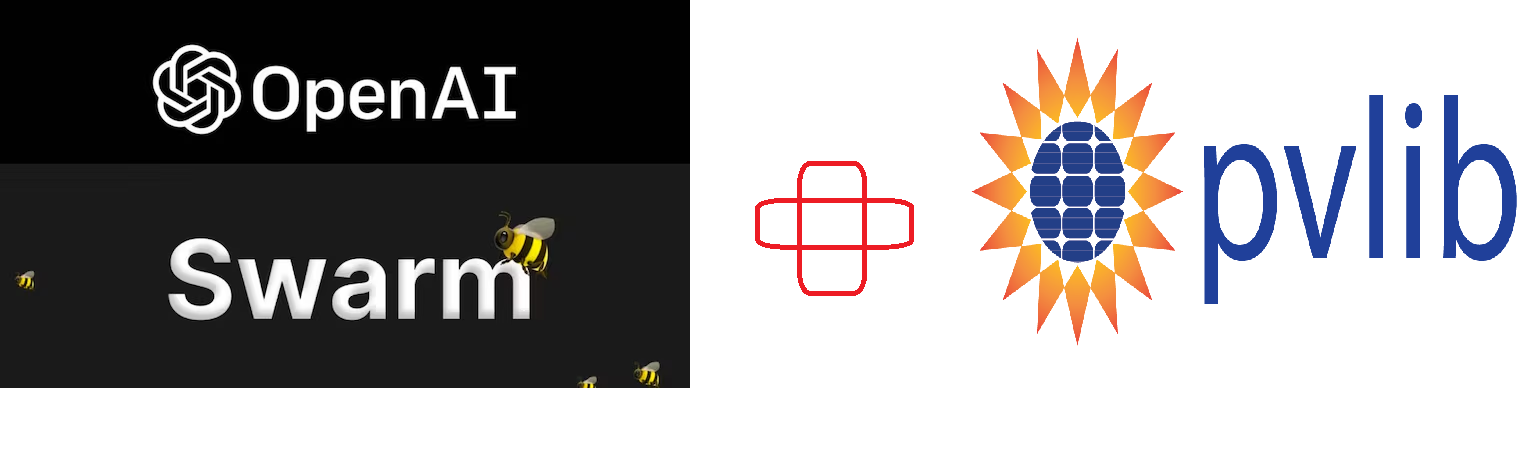

In [11]:
from IPython.display import Image
Image('./swarm_pvlib.png')

In [ ]:
!pip install pvlib

In [7]:
import os
import pvlib
import pandas as pd
from google.colab import userdata
OPENAI_API_KEY = userdata.get('OPENAI_API_KEY')
os.environ['OPENAI_API_KEY'] = OPENAI_API_KEY
from swarm import Swarm, Agent


In [8]:
from swarm import Swarm, Agent
client = Swarm()

In [10]:
from swarm import Swarm, Agent

client = Swarm()

# Define functions for agents
def calculate_solar_position(lat, lon, datetime):
    times = pd.date_range(datetime, periods=1, freq='H', tz="UTC")
    solar_position = pvlib.solarposition.get_solarposition(times, lat, lon)
    return solar_position.to_dict()

def calculate_irradiance(lat, lon, tilt, azimuth, datetime):
    times = pd.date_range(datetime, periods=1, freq='H', tz="UTC")
    solar_position = pvlib.solarposition.get_solarposition(times, lat, lon)
    dni_extra = pvlib.irradiance.get_extra_radiation(times)
    airmass = pvlib.atmosphere.get_relative_airmass(solar_position['apparent_zenith'])
    poa = pvlib.irradiance.get_total_irradiance(
        surface_tilt=tilt,
        surface_azimuth=azimuth,
        dni=800,  # Dummy DNI value
        ghi=1000, # Dummy GHI value
        dhi=200,  # Dummy DHI value
        solar_zenith=solar_position['apparent_zenith'],
        solar_azimuth=solar_position['azimuth']
    )
    return poa.to_dict()

def calculate_power_output(poa_irradiance, system_capacity=5):
    # Assume a simple efficiency model for demonstration
    efficiency = 0.2  # 20% panel efficiency
    print(poa_irradiance)
    power_output =  300 #int(system_capacity) * int(efficiency) *
    return {"ac_power": power_output}

# Define Agents
solar_position_agent = Agent(
    name="Solar Position Agent",
    instructions="Calculate solar position based on location and time.",
    functions=[calculate_solar_position]
)

irradiance_agent = Agent(
    name="Irradiance Agent",
    instructions="Calculate the plane of array (POA) irradiance based on solar position and weather data.",
    functions=[calculate_irradiance]
)

power_output_agent = Agent(
    name="Power Output Agent",
    instructions="Estimate AC power output of a PV system based on irradiance and system parameters.",
    functions=[calculate_power_output]
)

# Supervisor to route requests
def route_request(context_variables):
    user_message = context_variables.get("last_user_message", "")
    if "solar position" in user_message.lower():
        return solar_position_agent
    elif "irradiance" in user_message.lower():
        return irradiance_agent
    elif "power output" in user_message.lower():
        return power_output_agent
    else:
        return "I'm sorry, I don't understand your request."

supervisor_agent = Agent(
    name="Supervisor Agent",
    instructions="Route the user's request to the appropriate agent: Solar Position, Irradiance, or Power Output.",
    functions=[route_request]
)

# User input
user_message = "What's the power output of a 5 kW system in San Diego at 2 PM on 10 Oct?"
context_variables = {
    "last_user_message": user_message,
    "lat": 32.7157,  # Latitude for San Diego
    "lon": -117.1611,  # Longitude for San Diego
    "tilt": 30,  # Panel tilt
    "azimuth": 180,  # Panel azimuth facing south
    "datetime": "2020-10-10 14:00:00",
    "debug": True
}

response = client.run(
    agent=supervisor_agent,
    messages=[{"role": "user", "content": user_message}],
    context_variables=context_variables
)

print(response.messages[-1]["content"])


1000
The power output of a 5 kW PV system in San Diego at 2 PM on October 10th is approximately 300 watts.
